In [ ]:
from google.colab import drive as drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Spam Classificateur

## Paramère empiriques

In [ ]:
k = 400

## Importation des librairie

In [ ]:
import os
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from time import time
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Préparation des données

### Importation des emails

#### Fonctions utilitées

In [ ]:
def get_data(path):
    encoding = "ISO-8859-1"
    data = []
    files = os.listdir(path)
    print(files)
    path=path+"/"
    for filename in files:
        
        file = open(f"{path}{filename}", encoding=encoding)
        
        words_list = file.read()
        data.append(words_list)
        file.close()
    return data

#### Implémentation

In [ ]:
# données
#ham = no spam , and spam is spam
easy_ham_path1 = "/content/gdrive/MyDrive/ProjectAirn/emails/easy_ham"

hard_ham_path1 = "/content/gdrive/MyDrive/ProjectAirn/emails/20021204_hard_ham"


spam_path1 = "/content/gdrive/MyDrive/ProjectAirn/emails/spam"
spam_path2 = "/content/gdrive/MyDrive/ProjectAirn/emails/20021009_spam"
spam_path3 = "/content/gdrive/MyDrive/ProjectAirn/emails/20021204_spam"
#spam_path4 = "/content/gdrive/MyDrive/ProjectAirn/emails/20021204_spam_2"

easy_ham1 = get_data(easy_ham_path1)

hard_ham1 = get_data(hard_ham_path1)


spam1 = get_data(spam_path1)
spam2 = get_data(spam_path2)
spam3 = get_data(spam_path3)
#spam4 = get_data(spam_path4)

ham = easy_ham1 + hard_ham1 
spam = spam1 + spam2 + spam3

['1545.f12974e0310c366731631a0a62980b5c', '1417.cc31f571d364ed7214cdcc48917f97f4', '1519.6074b997fafe25f524f2e2334f7ae45e', '1524.d18213f1cf68518e719dccd3717e4255', '1434.a626ce397e7a295eea36a996cdaa5f40', '1521.692de69e480a819f6d32578f93fca74b', '1419.21567426907fe2711bcb2cbff50a46e8', '1532.7629e5bf068e857d0149f49caf32df6f', '1381.3c5527db01789ad42005006ac2ed2fcc', '1351.c176f7e5d80492c34cad40bc9e939012', '1601.e586e85a3d75cc48f9b913f244d52632', '1461.7a96cf16c999d9db5e0cf0369203866d', '1615.bb0721aadf9f170a979323adf11c22d5', '1432.0b1b8088c9a4e04cff33f6919f340402', '1365.83f365382e725776956f137a4600117e', '1595.fa533692bb0d635d6d1219663ee0f82c', '1356.14e3ab9f37daa13ce7a15770017c4863', '1528.e2fa148e32e3c975b3afff6959c2ab6b', '1352.dde8603b55106a1e7fe9508e972b24d2', '1425.7ed3569c34399b07b158eaead1c85cc8', '1458.41929f2d84553fee75ee83a78d735972', '1331.6ad39d03e006435853139ea69757b8f4', '1437.8bf8819fa24490f892b73ba41821d950', '1459.74fc3984acd4e3e9f00e77f599d2fe27', '1481.a18fd231d

### Traitement des emails

#### Fonctions d'utilitées

In [ ]:
def radicalize(word):
  suffixes = [("sses", "ss"), ("ies", "i"), ("ss", "ss"), ("s", ""), ("ing", "")]
  for suffix, replacement in suffixes:
    if word.endswith(suffix):
      # do something
      word = word[::-1].replace(suffix[::-1], replacement[::-1])[::-1]
      break

  return word

In [ ]:
# normalization of emails
def normalize(email):
    # to lowercase
    email = email.lower()

    # balise html
    email, *rest = re.subn(r"<[^>]+>", "  ", email)

    # url
    email, *rest = re.subn(r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)", " httpaddr ", email)

    # email address
    email, *rest = re.subn(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)", " emailaddr ", email)

    # nombre
    email, *rest = re.subn(r"\d+(\.\d+)?", " nombre ", email)

    # dollar
    email, *rest = re.subn(r"\$", " dollar ", email)

    # ponctuation
    email, *rest = re.subn(r"[!\"$%&'()*+,-./:;<=>?@[\]^_`{|}~]", "  ", email)

    # \t & \n
    email, *rest = re.subn(r"[\t\n]", "  ", email)

    # space
    email, *rest = re.subn(r"\s{2,}", " ", email)

    # strip whitespace
    email = email.strip()

    # radicalisation
    email_list = email.split(" ")

    email_list = [radicalize(word) for word in email_list]

    email_list = list(filter(lambda a: a != '', email_list))

    email = " ".join(email_list)

    return email

#### Implémentation

In [ ]:
preprocessed_ham = [normalize(email) for email in ham]
print("preprocessing ham emails done...")
preprocessed_spam = [normalize(email) for email in spam]
print("preprocessing spam emails done...")

preprocessing ham emails done...
preprocessing spam emails done...


### Construction du vocabulaire

#### Fonctions d'utilitées

In [ ]:
def get_k_most_common_words(email_list, k):
    word_list = []
    for email in email_list:
        split_email = email.split(" ")
        word_list += list(filter(lambda word: len(word) != 1, split_email))

    counter = Counter(word_list)
    k_most_common_words_with_count = counter.most_common(k)
    k_most_common_words = [word for word, _ in k_most_common_words_with_count]
    return k_most_common_words

In [ ]:
vocabulary = get_k_most_common_words(preprocessed_spam, k)
vocabulary_string = ", ".join(vocabulary)

path = "./vocabulaire.txt"
with open(path, "w", encoding="utf-8") as file:
    file.write(vocabulary_string)

### Construction of X and y

In [ ]:
data = []
for emails, label in [(preprocessed_ham, 0), (preprocessed_spam, 1)]:
    for email in emails:
        email_word_list = email.split(" ")
        email_counter = Counter(email_word_list)

        data_i = []
        for word in vocabulary:
            data_i.append(email_counter[word])
        data_i.append(label)
        data.append(data_i)
data = np.array(data)

In [ ]:
X = data[:, :len(vocabulary)]
y = data[:, len(vocabulary)]

# rajoutons l'ordonnée à l'origine theta 0
intercept=np.ones((data.shape[0],1)) 
X=np.column_stack((intercept,X))

X, y

(array([[  1., 172.,   5., ...,   0.,   0.,   0.],
        [  1., 127.,   3., ...,   0.,   0.,   0.],
        [  1., 115.,   5., ...,   0.,   0.,   0.],
        ...,
        [  1.,  62.,   8., ...,   0.,   0.,   0.],
        [  1.,  66.,  25., ...,   0.,   0.,   3.],
        [  1., 153.,  19., ...,   0.,   2.,   0.]]),
 array([0, 0, 0, ..., 1, 1, 1]))

# Représentation des emails

In [ ]:
data_words = []
for emails, label in [(preprocessed_ham, 0), (preprocessed_spam, 1)]:
    for email in emails:
        email_word_list = email.split(" ")
        email_counter = Counter(email_word_list)
        data_i = []
        for word in vocabulary:
            data_i.append((word,email_counter[word]))
        data_words.append(data_i)

data_words.sort(key = lambda x: x[1])

In [ ]:
len(data_words[0])

400

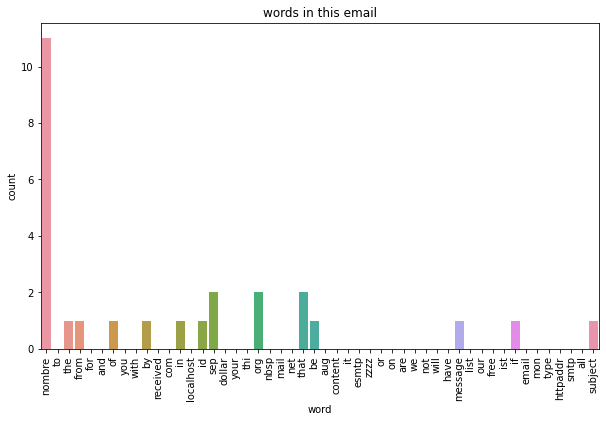

In [ ]:
temp = pd.DataFrame(data_words[0][:50],  columns=['word', 'count'])
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x='word', y='count', 
            data=temp, ax=ax)
plt.title("words in this email")
plt.xticks(rotation='vertical');

## Apprentissage

### Statistiques

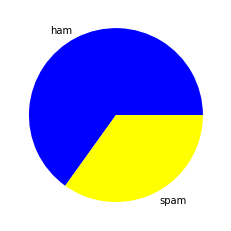

In [ ]:
ones = (y == 1).sum()
zeros = (y == 0).sum()

labels = ['ham', 'spam']
colors = ['blue', 'yellow']
plt.pie([zeros, ones], labels=labels, colors=colors)
plt.show()

In [ ]:
X.shape, y.shape

((4303, 401), (4303,))

### Découpage des données

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

y_train_s = y_train.reshape( y_train.shape[0], 1)
y_test_s = y_test.reshape( y_test.shape[0], 1)

In [ ]:
X_train.shape

(3442, 401)

### Definition of Models


## Logistic regression

#a- from scratch

In [ ]:
X2 = X_train
X2.shape

(3442, 401)

In [ ]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z));

In [ ]:
# cost function
def computeCost(X, y, theta, lambdaa = 1):
    m = len(y)
    y_pred = Sigmoid(np.dot(X, theta))
    error = y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)
    cost = - 1 / m * np.sum(error)
    return cost

In [ ]:
def gradientDescent(X, y, theta, alpha, iterations, lambda_):
    m=len(y)
    for iter in range(iterations):
      hypothesis = Sigmoid(np.dot(X[1:,:],theta)) - y[1:,:]
      diff = (hypothesis * X[1:,:])
      for j in range(len(theta)):
         theta[j] = theta[j] - alpha * ((1/m) * np.sum(diff[:,j]))
    return theta

In [ ]:
# use the definied functions
n = X2.shape[1]
theta = np.zeros((n, 1))

In [ ]:
initialCost = computeCost(X2, y_train, theta)
print(initialCost)

2385.812595487242


In [ ]:
n=X2.shape[1]
initial_theta = np.zeros((n, 1))
# paramètres
MaxIter = 200;
alpha = 0.0001;

# paramètre de regression
lambdaa = 0.1;

#appel
start = time()
theta = gradientDescent(X2, y_train_s, initial_theta, alpha, MaxIter,lambdaa)
finish = time()
print(f"training is done in {finish - start} seconds...")

training is done in 3.3244152069091797 seconds...


In [ ]:
cost=computeCost(X2, y_train_s, theta)
print(cost)

0.5446263727293807


In [ ]:
y_train_s.shape

(3442, 1)

In [ ]:
def predict(X):
     i = 0
     j = 0
     exp = 0
     pred_vect = []
     m = y_train.shape[0]
     while (i < X.shape[0]):
        exp = 0
        while j<theta.shape[0]:
          exp += X[i][j]* theta[j][0]
          j+=1
        
        if (Sigmoid(exp)>0.5):
            pred_vect.append(1)
        else:
            pred_vect.append(0)
        
        i+=1
        
     return pred_vect

In [ ]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred = predict(X_test)
precision = np.mean(y_test_s == y_pred)*100
print(precision)

64.69221835075494


# b- with Scikit-Learn

In [ ]:
from sklearn.linear_model import LogisticRegression

# define the model
logisticRegr = LogisticRegression()

# train the model
start = time()
logisticRegr.fit(X_train, y_train)
finish = time()
print(f"training is done in {finish - start} seconds...")

training is done in 0.256519079208374 seconds...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
# test
y_pred = logisticRegr.predict(X_test)
precision = np.mean(y_test ==y_pred)*100
print(precision)

99.07084785133566


#Abre de décision

In [ ]:
clf_tree = tree.DecisionTreeClassifier()

In [ ]:
start = time()
clf_tree.fit(X_train, y_train)
finish = time()
print(f"fitting decision tree classifier is done in {finish - start} seconds...")

fitting decision tree classifier is done in 0.16692900657653809 seconds...


In [ ]:
print(clf_tree.score(X_test,y_test)*100)

97.90940766550523


#KNN classifier

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=3)

In [ ]:
start = time()
clf_knn.fit(X_train, y_train)
finish = time()
print(f"fitting decision knn classifier is done in {finish - start} seconds...")

fitting decision knn classifier is done in 0.0023212432861328125 seconds...


In [ ]:
print(clf_knn.score(X_test,y_test)*100)

95.81881533101046


#Classification bayésienne

In [ ]:
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn import *
from matplotlib.colors import ListedColormap
import seaborn as sns

clf = GaussianNB().fit(X_train, y_train)

# Calcul de la matrice de confusion

disp = metrics.plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['a','e','e\_aigu','e\_grave','i','o','o\_ouvert','ou','u'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Matrice de Confusion GaussianNB')

#confusion_matrix(y_true, y_pred)


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#instanciation
model_Gaussian = GaussianNB()

#training
start = time()
model_Gaussian.fit(X_train, y_train)
finish = time()
print(f"training is done in {finish - start} seconds...")

#prédiction
prediction = model_Gaussian.predict(X_test)
print(prediction)

#evaluation du modèle
precision = accuracy_score(y_test, prediction)*100
print(precision)

training is done in 0.03592061996459961 seconds...
[1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0
 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0
 0 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1
 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1
 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1
 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0 0 1 1 0 0 1
 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 

# Simple neural network from scratch 

### définir la structure du réseau de neurones

In [ ]:
input_layer_size  = k
hidden_layer_size = 25
num_labels = 2


In [ ]:
X_test.shape

(861, 401)

In [ ]:
def Sigmoid(z):
    # pour une valeur donnée, cette fonction calculera sa sigmoid
    return 1/(1+np.exp(-z))

In [ ]:
def computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_, regularization):
    a1=X; 
    m = X.shape[0]

    z2= np.zeros((X.shape[0],hidden_layer_size)) 
    a2= np.zeros((X.shape[0],hidden_layer_size)) 

    intercept=np.ones((X.shape[0],1))
    z2=np.column_stack((intercept,np.matmul(a1,np.transpose(theta1)))) 
    a2=Sigmoid(z2)
    a2[:,0]=1

    z3= np.zeros((YY.shape[0],YY.shape[1]))    
    a3= np.zeros((YY.shape[0],YY.shape[1]))  

    z3=np.matmul(a2,np.transpose(theta2))
    a3=Sigmoid(z3)

    J=np.zeros((YY.shape[0],1))
    J= (1/y.shape[0])*(np.sum(np.sum((-YY*np.log(a3))-((1-YY)*np.log(1-a3)))));

    #rergularization part
    if regularization : 
      Theta1_sum = np.sum(np.square(theta1[:,1:])) 
      Theta2_sum = np.sum(np.square(theta2[:,1:])) 
      reg_term = Theta1_sum + Theta2_sum 
      
      J += (lambda_ / (2 * m)) * reg_term 

    return J

In [ ]:
def sigmoidGradient(z):
    sigmoid_prime = Sigmoid(z) * (1 - Sigmoid(z))
    return sigmoid_prime

In [ ]:
def NNCostFunction(nn_params, X, YY, hidden_layer_size, lambda_, regularization): # retourner le cout + le gradient delta

    theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],(hidden_layer_size, input_layer_size + 1)) 
    theta2 = np.reshape(nn_params[hidden_layer_size * (input_layer_size + 1):],(num_labels, hidden_layer_size + 1))

    m = X.shape[0]
    # forward propagation
    # a2
    z2 = np.dot(X, theta1.T)
    a2 = Sigmoid(z2) 

    # a3
    # add bias unit to a2
    a2 = np.insert(a2, 0, 1, axis=1)
    z3 = np.dot(a2, theta2.T)
    a3 = Sigmoid(z3) 

    # create a y matrix of shape (m, K) for later use 
    y_hat = np.zeros((m, YY.shape[1])) 

    # initialize Delta matrices
    D1 = np.zeros((hidden_layer_size, input_layer_size + 1)) 
    D2 = np.zeros((num_labels, hidden_layer_size + 1)) 

    # for each training example
    for t in range(m):
        x_t = X[t]

        # back Propagation and gradients computation
        # Ccmpute the error of the last layer
        d_3 = a3[t] - YY[t] 
        d_3 = d_3.reshape(-1,1) 

        # perform back propagation
        d_2 = np.dot(theta2.T[1:,:], d_3) * sigmoidGradient(z2[t].reshape(-1,1))

        # update the delta matrices
        D1 += np.dot(d_2, x_t.reshape(-1, 1).T) 
        D2 += np.dot(d_3, a2[t].reshape(1,-1)) 

    # compute total cost 
    J = computeCost(X, YY, theta1, theta2, hidden_layer_size, lambda_, regularization)

    # update our new Delta matrices with regularization (all columns expect the first one which represents bias term)
    if regularization :
      D1 = D1 / m
      D2 = D2 / m
      D1[:,1:] = D1[:,1:] + (lambda_ / m) * theta1[:,1:]
      D2[:,1:] = D2[:,1:] + (lambda_ / m) * theta2[:,1:]

    # unroll delta
    Deltas = [D1, D2]
    unrolled_Deltas = [Deltas[i].ravel() for i,_ in enumerate(Deltas)]
    grad = np.concatenate(unrolled_Deltas)

    return J, grad

# Entrainement du réseau

In [ ]:
from scipy.optimize import minimize
def gradientDescent(X, YY, theta1, theta2, alpha, iterations, lambda_, regularization):
    # unroll parameters
    theta = [theta1, theta2]
    unrolled_Thetas = [theta[i].ravel() for i,_ in enumerate(theta)]
    nn_params = np.concatenate(unrolled_Thetas)

    #optimize the cost function
    results = minimize(fun=NNCostFunction,
                       x0=nn_params,
                       args=(X, YY, hidden_layer_size, lambda_, regularization),
                             method='CG',
                             jac=True,
                             options={'maxiter':iterations, 'disp': True})
    theta = results.x

    return theta

# Régularisation

In [ ]:
y_train.shape, X_train.shape

((3442,), (3442, 401))

In [ ]:
# parameters
iterations = 100;
alpha = 0.03;
lambda_ = 0.9;

W1 = np.zeros((hidden_layer_size, k+1))
W2 = np.zeros((num_labels, hidden_layer_size+1))

In [ ]:
# without regularization
regularization = False
start = time()
theta = gradientDescent(X_train, y_train_s, W1, W2, alpha, iterations, lambda_, regularization)
finish = time()
print(f"training is done in {finish - start} seconds...")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


         Current function value: 0.107569
         Iterations: 100
         Function evaluations: 806
         Gradient evaluations: 806
training is done in 182.982515335083 seconds...


In [ ]:
# with regularization
regularization = True
start = time()
theta = gradientDescent(X_train, y_train_s, W1, W2, alpha, iterations, lambda_, regularization)
finish = time()
print(f"training is done in {finish - start} seconds...")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


         Current function value: 0.155912
         Iterations: 100
         Function evaluations: 345
         Gradient evaluations: 341
training is done in 85.76410174369812 seconds...


# Prediction

In [ ]:
def predict (W1, W2, X):
    # appliquer une propagation en avant
    # !--- n'oubliez pas d'appliquer la sigmoid à chaque couche afin d'avoir les probabilités ---!
    
    # prédire la classe en choisissant la probabilité maximale parmi les 10 noeuds de sortie
     y_pred = []
     for k in range(X.shape[0]):
        #from input layer to hidden layer
        hidden_layer = []
        for i in range(W1.shape[0]):
          a = 0
          for j in range(1, W1.shape[1]):
            a+= X[k][j] * W1[i][j] 
          a = Sigmoid(a + W1[i][0])
          hidden_layer.append(a)
  
        #from hidden layer to output layer
        output_layer = []
        for i in range(W2.shape[0]):
          a = 0
          for j in range(1, W2.shape[1]):
            a+= hidden_layer[j-1] * W2[i][j] 
          a = Sigmoid(a + W2[i][0])
          output_layer.append(a)
        
        #output layer
        #print(output_layer)
        classe = output_layer.index(max(output_layer))
        y_pred.append(classe)
          
     return y_pred

In [ ]:
# calcul de precision = nombre de valeurs bien prédites (ici sur toute la base X)
y_pred=predict(W1, W2, X_test)

In [ ]:
p=0
for i in range(len(y_pred)):
  if y_pred[i]==y_test[i]:
    p+=1
precision = p*100 / y_test.shape[0]
precision

64.69221835075494

#Neural network


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras import datasets, layers, models
import tensorflow as tf

In [ ]:
X_train.shape

(3442, 401)

In [ ]:
model1 = Sequential()
model1.add(Dense(100))
model1.add(layers.Dense(10))
model1.add(layers.Dense(1))
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
start = time()
model1.fit(X_train, y_train, epochs = 25, verbose = 0)
finish = time()
print(f"training is done in {finish - start} seconds...")

training is done in 5.662003993988037 seconds...


In [ ]:
model1.evaluate(X_test,y_test)

27/27 [==============================] - 0s 2ms/step - loss: 5.4462 - accuracy: 0.6469


[5.4462080001831055, 0.6469221711158752]

In [ ]:
model2 = Sequential()
model2.add(Dense(4, activation='relu'))
model2.add(layers.Dense(4, kernel_initializer='normal',activation='relu'))
model2.add(layers.Dense(1,kernel_initializer='normal', activation='sigmoid'))
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

start = time()
model2.fit(X_train, y_train, epochs = 25, verbose = 0)
finish = time()
print(f"training is done in {finish - start} seconds...")

training is done in 5.652086019515991 seconds...


In [ ]:
loss, accuracy = model2.evaluate(X_test, y_test)
print(f' Model loss on the test set: {loss}')
print(f' Model accuracy on the test set: {100*accuracy}')

27/27 [==============================] - 0s 1ms/step - loss: 0.3402 - accuracy: 0.9930
 Model loss on the test set: 0.3402310013771057
 Model accuracy on the test set: 99.303138256073


###SVM 
Nous utiliserons ici une MVS avec differents noyaux:
- Linéaire
- Gaussien (RBF)
- Polyomial

In [ ]:
C = 1000# SVM regularization parameter
classifier_svm_linear = SVC(kernel='linear', random_state=0)
rbf_svc = svm.SVC(kernel='rbf', gamma=25, C=C)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C)
start = time()

### Apprentissage

In [ ]:
start = time()
classifier_svm_linear.fit(X_train, y_train)
finish = time()
print(f"fitting linear svm classifier is done in {finish - start} seconds...")

fitting linear svm classifier is done in 0.8801321983337402 seconds...


In [ ]:
start = time()
rbf_svc.fit(X_train, y_train)
finish = time()
print(f"fitting svm classifier with rbf kernel is done in {finish - start} seconds...")

fitting svm classifier with rbf kernel is done in 2.0380208492279053 seconds...


In [ ]:
start = time()
poly_svc.fit(X_train, y_train)
finish = time()
print(f"fitting  svm classifier with polynomial kernel is done in {finish - start} seconds...")

fitting  svm classifier with polynomial kernel is done in 1.740591287612915 seconds...


### Evaluation

In [ ]:
print("svm with linear kernel : ", classifier_svm_linear.score(X_test,y_test)*100)
print("svm with rbf kernel : ", rbf_svc.score(X_test,y_test)*100)
print("svm with polynomial kernel : ", poly_svc.score(X_test,y_test)*100)

svm with linear kernel :  99.1869918699187
svm with rbf kernel :  82.92682926829268
svm with polynomial kernel :  66.43437862950059


#MLP Classifier

In [ ]:
classifier_nn = MLPClassifier(random_state=1, max_iter=300)

In [ ]:
start = time()
classifier_nn.fit(X_train, y_train)
finish = time()
print(f"fitting neural network classifier is done in {finish - start} seconds...")

fitting neural network classifier is done in 4.509639501571655 seconds...


In [ ]:
print(classifier_nn.score(X_test,y_test)*100)

99.76771196283391
